# Predict Bike Sharing Demand with AutoGluon

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "santhoshchakilam"
kaggle_key = "bab54ee1cc38a15c5c3d45f3b0bbe785"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
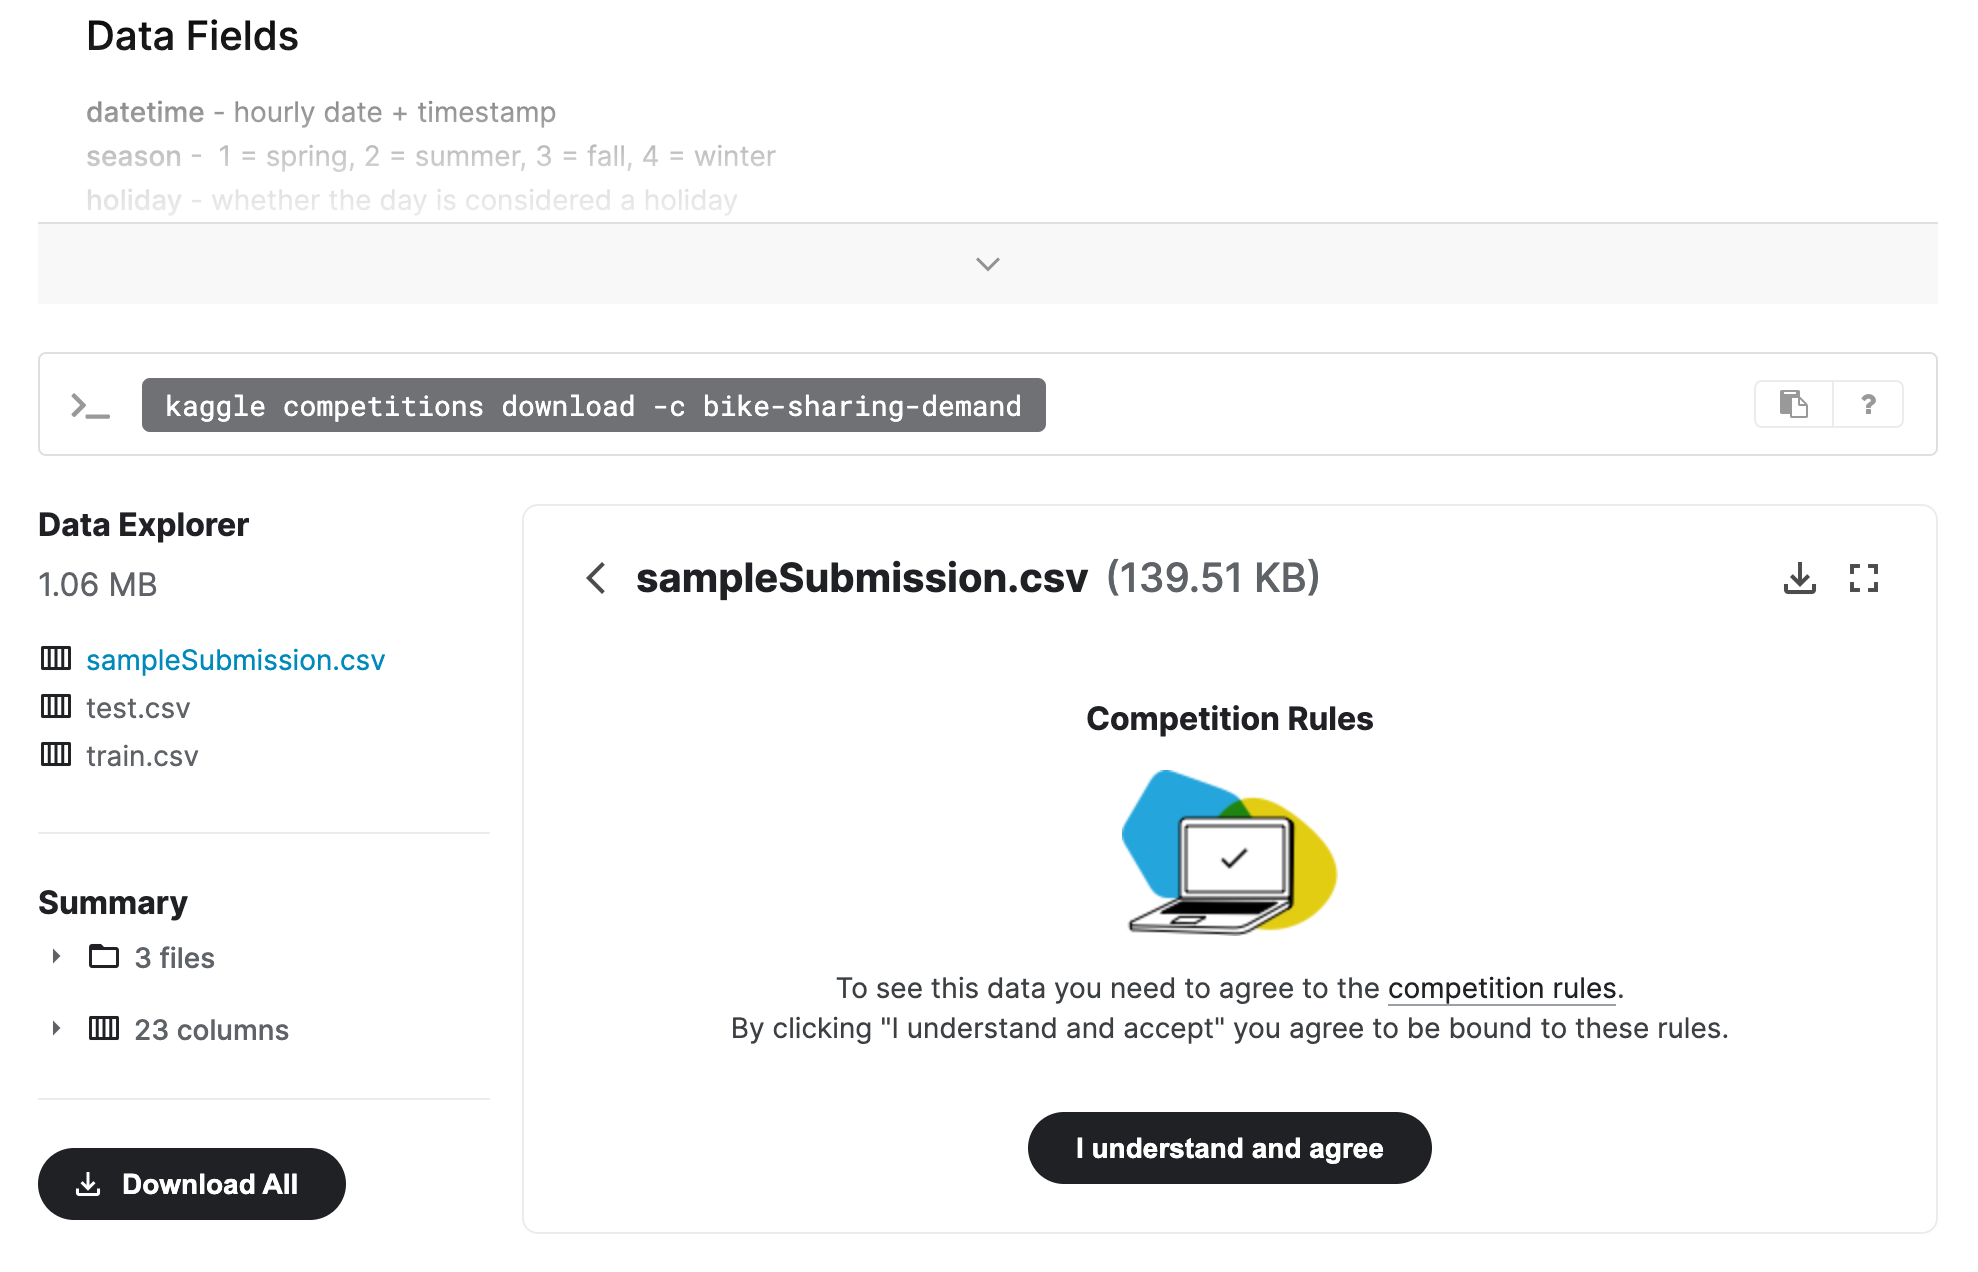

In [5]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
train.drop(["casual","registered"], axis=1, inplace=True)

In [13]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [14]:
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221014_070747/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221014_070747/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator..

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.797488      11.014542  444.828362                0.000846           0.354920            3       True         15
1   RandomForestMSE_BAG_L2  -53.379650      10.183484  412.670993                0.582994          26.114045            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.809183      10.201397  394.713190                0.600908           8.156242            2       True         14
3          LightGBM_BAG_L2  -55.138805       9.829794  410.203155                0.229304          23.646207            2       True         11
4          CatBoost_BAG_L2  -55.754888       9.707933  450.409434                0.107443          63.852486            2       True         13
5        LightGBMXT_BAG_L2  -60.415684      12.878155  439.872010         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [16]:
predictions = predictor.predict("test.csv")
predictions.head()

Loaded data from: test.csv | Columns = 9 / 9 | Rows = 6493 -> 6493


0    23.416422
1    40.975899
2    44.625340
3    48.279743
4    51.013332
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.611198
std        90.131088
min         3.083045
25%        20.515732
50%        62.612183
75%       170.097137
max       363.919922
Name: count, dtype: float64

In [18]:
# How many negative values do we have?
(predictions<0).sum()

0

In [19]:
# Set them to zero
predictions[predictions<0] = 0

In [20]:
(predictions<0).sum()

0

### Set predictions to submission dataframe, save, and submit

In [21]:
submission["count"] = pd.DataFrame(predictions)
submission.to_csv("submission.csv", index=False)

In [22]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 383kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [23]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2022-10-14 07:18:43  first raw submission               complete  1.80877      1.80877       
submission_new_hpo.csv       2022-10-13 23:23:45  new features with hyperparameters  error                                
submission_new_hpo.csv       2022-10-13 23:10:48  new features with hyperparameters  error                                
submission_new_hpo.csv       2022-10-13 22:57:01  new features with hyperparameters  complete  1.33179      1.33179       


#### Initial score of `1.80877`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

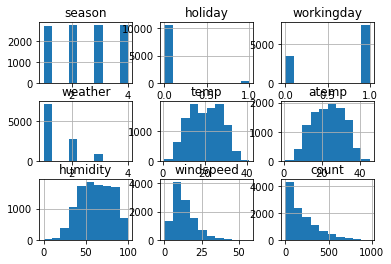

In [24]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist();

In [25]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [27]:
# create a new feature
#train['time_hour'] = train['datetime'].dt.strftime("%H")
#test['time_hour'] = test['datetime'].dt.strftime("%H")
#train['time_year'] = train['datetime'].dt.strftime("%Y")
#test['time_year'] = test['datetime'].dt.strftime("%Y")
train['time_month'] = train['datetime'].dt.strftime("%M")
test['time_month'] = test['datetime'].dt.strftime("%M")

In [28]:
train.drop(['datetime'], axis=1, inplace=True)

In [29]:
test.drop(['datetime'], axis=1, inplace=True)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [30]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time_month
0,1,0,0,1,9.84,14.395,81,0.0,16,00
1,1,0,0,1,9.02,13.635,80,0.0,40,00
2,1,0,0,1,9.02,13.635,80,0.0,32,00
3,1,0,0,1,9.84,14.395,75,0.0,13,00
4,1,0,0,1,9.84,14.395,75,0.0,1,00


In [31]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [32]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time_month
0,1,0,0,1,9.84,14.395,81,0.0,16,00
1,1,0,0,1,9.02,13.635,80,0.0,40,00
2,1,0,0,1,9.02,13.635,80,0.0,32,00
3,1,0,0,1,9.84,14.395,75,0.0,13,00
4,1,0,0,1,9.84,14.395,75,0.0,1,00


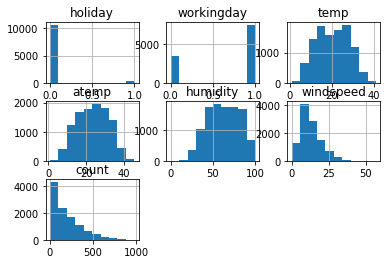

In [33]:
# View histogram of all features again now with the hour feature
train.hist();

## Step 5: Rerun the model with the same settings as before, just with more features

In [34]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time_month
0,1,0,0,1,9.84,14.395,81,0.0,16,00
1,1,0,0,1,9.02,13.635,80,0.0,40,00
2,1,0,0,1,9.02,13.635,80,0.0,32,00
3,1,0,0,1,9.84,14.395,75,0.0,13,00
4,1,0,0,1,9.84,14.395,75,0.0,1,00


In [35]:
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221014_071917/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221014_071917/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator..

In [36]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -139.675161       6.881780  522.071759                0.000779           0.408504            3       True         18
1     ExtraTreesMSE_BAG_L2 -140.316199       6.116659  385.123808                0.590784           7.255739            2       True         16
2          CatBoost_BAG_L2 -140.794256       5.647910  440.712448                0.122035          62.844379            2       True         15
3        LightGBMXT_BAG_L2 -141.004481       5.830471  399.275054                0.304597          21.406986            2       True         12
4   NeuralNetFastAI_BAG_L2 -141.170186       6.024218  430.679440                0.498344          52.811372            2       True         17
5          LightGBM_BAG_L2 -141.214944       5.669837  398.751765         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsemb

In [37]:
# Remember to set all negative values to zero
predictions_new_feature = predictor_new_features.predict("test.csv")
predictions_new_feature.head()

Loaded data from: test.csv | Columns = 9 / 9 | Rows = 6493 -> 6493


0    130.213776
1     71.675995
2     71.675995
3     91.293053
4     91.293053
Name: count, dtype: float32

In [38]:
predictions_new_feature[predictions_new_feature<0] = 0

In [39]:
(predictions_new_feature<0).sum()

0

In [40]:
submission_new_features = pd.read_csv("sampleSubmission.csv")
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [41]:
# Same submitting predictions
submission_new_features["count"] = pd.DataFrame(predictions_new_feature)
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [42]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|████████████████████████████████████████| 189k/189k [00:02<00:00, 96.3kB/s]
Successfully submitted to Bike Sharing Demand

In [43]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2022-10-14 07:30:31  new features                       complete  1.32921      1.32921       
submission.csv               2022-10-14 07:18:43  first raw submission               complete  1.80877      1.80877       
submission_new_hpo.csv       2022-10-13 23:23:45  new features with hyperparameters  error                                
submission_new_hpo.csv       2022-10-13 23:10:48  new features with hyperparameters  error                                


#### New Score of `1.32921`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [50]:
import autogluon.core as ag

nn_options = {
    'num_epochs': 10,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)
}
 
gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)
}

hyperparameters = {
    'GBM': gbm_options,
    'CAT': {'iterations': 10000},
    'RF': {'n_estimators': 300},
    'XT': {'n_estimators': 300},
    #'NN_MXNET': nn_options
} 
 
hyperparameter_tune_kwargs = { 
    'scheduler': 'local',
    'searcher': 'auto' 
}
 

In [51]:
predictor_new_hpo = TabularPredictor(label="count", verbosity=10, eval_metric="root_mean_squared_error").fit(train_data=train, time_limit=600, presets="best_quality", hyperparameters = hyperparameters, hyperparameter_tune_kwargs = hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20221014_073258/"
Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True,
 'hyperparameter_tune_kwargs': {'scheduler': 'local', 'searcher': 'auto'}}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'feature_prune_kwargs': None,
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': {'scheduler': 'local', 'searcher': 'auto'},
 'keep_only_best': False,
 'name_suffix': None,
 'num_bag_folds': None,
 'num_bag_sets': None,
 'num_stack_levels': None,
 'pseudo_data': None,
 'quantile_levels': None,
 'refit_full': False,
 'save_space': False,
 'set_best_to_refit_full': False,
 'unlabeled_data': None,
 'use_bag_holdout': False,
 'verbosity': 10}
Stack configuration (auto_sta

In [52]:
predictor_new_hpo.fit_summary()

Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T1/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T2/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T3/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T4/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T5/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T6/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T7/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T8/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T9/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T10/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T11/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T12/model.pkl
Loading: AutogluonModels/ag-20221014_

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    CatBoost_BAG_L2/T1 -139.624750       2.898999  329.041289                0.007071           4.002003            2       True         33
1   WeightedEnsemble_L2 -144.226804       0.759105   77.752431                0.001216           0.417503            2       True         26
2   WeightedEnsemble_L3 -144.664136       3.354105  396.524712                0.002196           0.352323            3       True         34
3    LightGBM_BAG_L2/T2 -144.768887       2.999540  342.370451                0.107613          17.331166            2       True         28
4    LightGBM_BAG_L1/T3 -144.769647       0.182239   15.923524                0.182239          15.923524            1       True          3
5   LightGBM_BAG_L1/T18 -144.828648       0.147431   15.310775                0.147431      

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T11': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T12': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T13': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T14': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T15': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T16': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T17': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T18': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T19': 'StackerEnsembl

In [53]:
# Remember to set all negative values to zero
predictions_new_hypo = predictor_new_hpo.predict("test.csv")
predictions_new_hypo.head()

File delimiter for test.csv inferred as ',' (comma). If this is incorrect, please manually load the data as a pandas DataFrame.
Loaded data from: test.csv | Columns = 9 / 9 | Rows = 6493 -> 6493
Loading: AutogluonModels/ag-20221014_073258/models/WeightedEnsemble_L2/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T10/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T18/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T3/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T7/model.pkl
Loading: AutogluonModels/ag-20221014_073258/models/LightGBM_BAG_L1/T8/model.pkl


0    115.352692
1     69.291794
2     69.291794
3     86.705589
4     86.705589
Name: count, dtype: float32

In [54]:
(predictions<0).sum()

0

In [55]:
submission_new_hpo = pd.read_csv("sampleSubmission.csv")
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [56]:
# Same submitting predictions
submission_new_hpo["count"] = pd.DataFrame(predictions_new_hypo)
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [57]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 334kB/s]
Successfully submitted to Bike Sharing Demand

In [58]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-10-14 07:44:22  new features with hyperparameters  complete  1.30702      1.30702       
submission_new_features.csv  2022-10-14 07:30:31  new features                       complete  1.32921      1.32921       
submission.csv               2022-10-14 07:18:43  first raw submission               complete  1.80877      1.80877       
submission_new_hpo.csv       2022-10-13 23:23:45  new features with hyperparameters  error                                


#### New Score of `1.30702`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

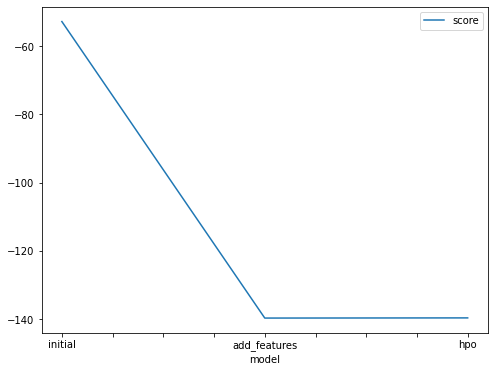

In [59]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [predictor.leaderboard(silent=True)['score_val'][0],
          predictor_new_features.leaderboard(silent=True)['score_val'][0],
          predictor_new_hpo.leaderboard(silent=True)['score_val'][0]]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

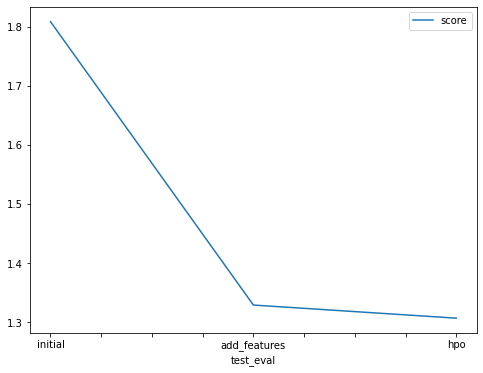

In [60]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80877, 1.32921, 1.30702]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [10]:
# The 3 hyperparameters we tuned with the kaggle score as the result
import pandas as pd
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default_values", "default_values", "num_epochs: 10, activation: ag.space.Categorical('relu', 'softrelu', 'tanh'), layers: ag.space.Categorical([100],[1000],[200,100],[300,200,100])"],
    "hpo2": ["default_values", "default_values", "GBM : num_boost_round': 100, num_leaves: ag.space.Int(lower=26, upper=66, default=36)"],
    "hpo3": ["default_values", "default_values", "default_values"],
    "score": [1.80877, 1.32921, 1.30702]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default_values,default_values,default_values,1.80877
1,add_features,default_values,default_values,default_values,1.32921
2,hpo,"num_epochs: 10, activation: ag.space.Categoric...","GBM : num_boost_round': 100, num_leaves: ag.sp...",default_values,1.30702
